In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.datasets import fashion_mnist
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from keras.utils import to_categorical

Using TensorFlow backend.


In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Functions

In [5]:
def multi_plot_data(data, labels):
    '''
    https://medium.com/@mjbhobe/mnist-digits-classification-with-keras-ed6c2374bd0e
    '''
    num_rows, num_cols = 2, 7
    f, ax = plt.subplots(num_rows, num_cols, figsize=(12,5),
                         gridspec_kw={'wspace':0.03, 'hspace':0.01}, 
                         squeeze=True)
    for r in range(num_rows):
        for c in range(num_cols):
            image_index = r * 7 + c
            ax[r,c].axis("off")
            ax[r,c].imshow(data[image_index], cmap='gray')
            ax[r,c].set_title('Class. %d' % labels[image_index])
    plt.show()
    plt.close()

In [6]:
def build_model(num_classes):
    '''
    creates a CNN model using Keras’ Sequential API with 
        3 Conv2D layers with 32, 64 and 64 filters each, 
        using the relu activation, kernel_size=(3,3) and padding=’same’
        Each Conv2D layer is followed immediately by a MaxPooling2D layer with a pool_size=(2,2)
        with 0.5 dropout to avoid overfitting
        follow this with a Dense layer with 512 nodes and relu activation
        output layer is a Dense layer with #num_classes nodes and softmax activation function
        compile the model with categorical_crossentropy loss and the adam optimizer.
    '''
    model = Sequential()
    # add Convolutional layers
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same',
                     input_shape=(image_height, image_width, num_channels)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))   
    model.add(Dropout(0.5))
    model.add(Flatten())
    # Densely connected layers
    model.add(Dense(128, activation='relu'))
    # output layer
    model.add(Dense(num_classes, activation='softmax'))
    # compile with adam optimizer & categorical_crossentropy loss function
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [7]:
def show_model_results(history):
    x_axis= list(range(len(history['val_acc'])))
    plt.plot(x_axis, history['val_acc'], '-o')
    plt.plot(x_axis, history['val_loss'], '-v')
    plt.legend(['val_acc', 'val_loss'])
    plt.grid()

## Read and look into the data

4423680/4422102 [==============================] - 3s 1us/step
(60000, 28, 28)


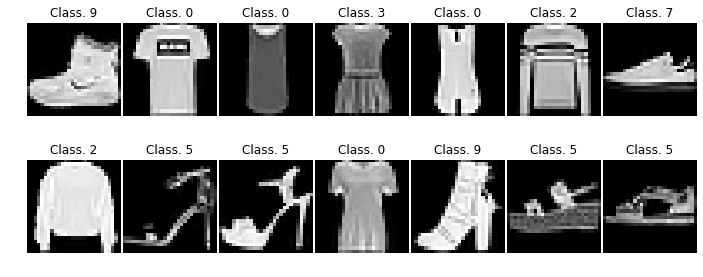

In [8]:
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

print(trainX.shape) 
image_height = trainX.shape[1]  
image_width = trainX.shape[2]
num_channels = 1 #grayscale data

multi_plot_data(trainX, trainY)

### Preprossing

In [8]:
# reshape
train_data = np.reshape(trainX, (trainX.shape[0], image_height, image_width, num_channels))
test_data = np.reshape(testX, (testX.shape[0], image_height, image_width, num_channels))

print(train_data.shape, test_data.shape)

# re-scale to [0-1]
train_data = train_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.

# one-hot encoding labels
num_of_classes = 10
train_labels = to_categorical(trainY, num_of_classes)
test_labels = to_categorical(testY, num_of_classes)

print(train_labels.shape, test_labels.shape)

# splitting train data into train and validation sets
np.random.seed(123) # use seed for consistent train validation data split
perc = int(0.10 * len(train_data)) # seperate 10% for validation
indexes = np.random.permutation(len(train_data)) # shuffled data 
train_data =train_data[indexes]
train_labels = train_labels[indexes]

train_data_val = train_data[:perc,:]
train_labels_val = train_labels[:perc,:]

train_data_t = train_data[perc:,:]
train_labels_t = train_labels[perc:,:]

print("train set shape: ", train_data_t.shape)
print("validation set shape: ", train_data_val.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)
(60000, 10) (10000, 10)
train set shape:  (54000, 28, 28, 1)
validation set shape:  (6000, 28, 28, 1)


## Train a CNN model and fit

In [9]:
model = build_model(num_of_classes)
print(model.summary())
epochs=50

mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

result = model.fit(train_data_t, train_labels_t, epochs=epochs, batch_size=64,
                   callbacks=[mcp_save, reduce_lr_loss],
                   validation_data=(train_data_val, train_labels_val))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________

/opt/conda/lib/python3.7/site-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 37s 678us/step - loss: 0.5903 - acc: 0.7817 - val_loss: 0.3537 - val_acc: 0.8767
Epoch 2/50
54000/54000 [==============================] - 36s 668us/step - loss: 0.3775 - acc: 0.8610 - val_loss: 0.2890 - val_acc: 0.8915
Epoch 3/50
54000/54000 [==============================] - 37s 677us/step - loss: 0.3250 - acc: 0.8805 - val_loss: 0.2627 - val_acc: 0.9007
Epoch 4/50
54000/54000 [==============================] - 37s 686us/step - loss: 0.2961 - acc: 0.8914 - val_loss: 0.2494 - val_acc: 0.9102
Epoch 5/50
54000/54000 [==============================] - 37s 684us/step - loss: 0.2721 - acc: 0.8989 - val_loss: 0.2340 - val_acc: 0.9153
Epoch 6/50
54000/54000 [==============================] - 37s 680us/step - loss: 0.2575 - acc: 0.9045 - val_loss: 0.2303 - val_acc: 0.9158
Epoch 7/50
54000/54000 [==============================] - 37s 686us/step - loss: 0.2446 - acc: 0.9087 - val_loss: 0.2

## Analyze the results

num of epochs:  50


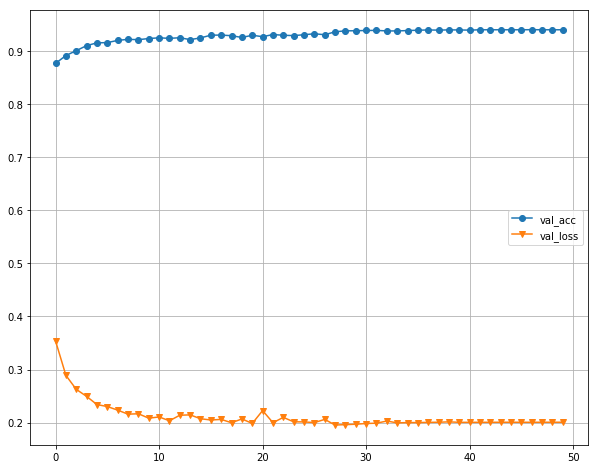

In [10]:
type(result.history)
result.history.keys()
print("num of epochs: ", len(result.history['val_loss']))
show_model_results(result.history)

## Test the best model with test set

In [11]:
test_results = model.evaluate(test_data, test_labels, batch_size=64)
print("test loss: ", test_results[0])
print("test accuracy: ", test_results[1])

10000/10000 [==============================] - 2s 164us/step
test loss:  0.212817649102211
test accuracy:  0.9331
